In [6]:
import os
import numpy as np
import sys
print(sys.executable)
import tensorflow as tf
from tensorflow.keras import layers, models
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


/home/nwertheim/Master-Thesis/thesisenv/bin/python


In [7]:
save_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA.npy")
target_data = np.load(save_dir, allow_pickle=True)
print(len(target_data))
print(target_data[0])
num_none_preterm = sum(1 for item in target_data if item['preterm'] is None)
print(f"Number of instances with None in 'preterm': {num_none_preterm}")
target_data = [item for item in target_data if item['preterm'] is not None]
print(f"Remaining instances after deletion: {len(target_data)}")
import matplotlib.pyplot as plt
from collections import Counter



1002
{'fs': 20, 'signal': array([-1.70318809, -3.4187089 , -2.48396297, ...,  0.73115951,
        0.40952615,  0.95038211]), 'record_name': 'Hopper-2023_05_25_12_03_38-0000010090-0003-chan0', 'preterm': 0}
Number of instances with None in 'preterm': 144
Remaining instances after deletion: 858


In [8]:
def create_windows(data, window_size):
    windowed_data = []
    for item in data:
        signal = item['signal']
        label = item['preterm']
        record_name = item['record_name']
        
        num_windows = len(signal) // window_size
        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window = signal[start:end]
            windowed_data.append({
                'signal': window,
                'label': label,
                'record_name': record_name
            })
    return windowed_data

WINDOW_SIZE = 12000
windowed_data = create_windows(target_data, WINDOW_SIZE)


In [9]:
X = np.stack([d['signal'] for d in windowed_data])
y = np.array([d['label'] for d in windowed_data])
record_names = [d['record_name'] for d in windowed_data]  # for aggregation later
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, rn_train, rn_test = train_test_split(
    X, y, record_names, stratify=y, test_size=0.3, random_state=42
)


In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [11]:
from collections import defaultdict, Counter
import re

# Step 1: Predict each window
y_pred = clf.predict(X_test)

# Step 2: Aggregate predictions per channel
channel_pred_dict = defaultdict(list)
channel_true_dict = {}

for pred, true, full_rec in zip(y_pred, y_test, rn_test):
    channel_pred_dict[full_rec].append(pred)
    channel_true_dict[full_rec] = true  # label is same for all windows in a channel

# Step 3: Majority vote per channel
channel_preds = {}
channel_truths = {}

for full_rec in channel_pred_dict:
    majority_vote = Counter(channel_pred_dict[full_rec]).most_common(1)[0][0]
    channel_preds[full_rec] = majority_vote
    channel_truths[full_rec] = channel_true_dict[full_rec]

# Step 4: Extract base recording name (remove -chanX)
def extract_base_record_name(rec_name):
    return re.sub(r'-chan\d+$', '', rec_name)

recording_pred_dict = defaultdict(list)
recording_true_dict = {}

for chan_name, pred in channel_preds.items():
    base_name = extract_base_record_name(chan_name)
    recording_pred_dict[base_name].append(pred)
    recording_true_dict[base_name] = channel_truths[chan_name]  # same across channels

# Step 5: Majority vote per recording
final_preds = []
final_truths = []

for base_name in recording_pred_dict:
    votes = recording_pred_dict[base_name]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_preds.append(majority_vote)
    final_truths.append(recording_true_dict[base_name])


              precision    recall  f1-score   support

           0       1.00      0.11      0.20        54
           1       0.65      1.00      0.79        89

    accuracy                           0.66       143
   macro avg       0.82      0.56      0.49       143
weighted avg       0.78      0.66      0.57       143



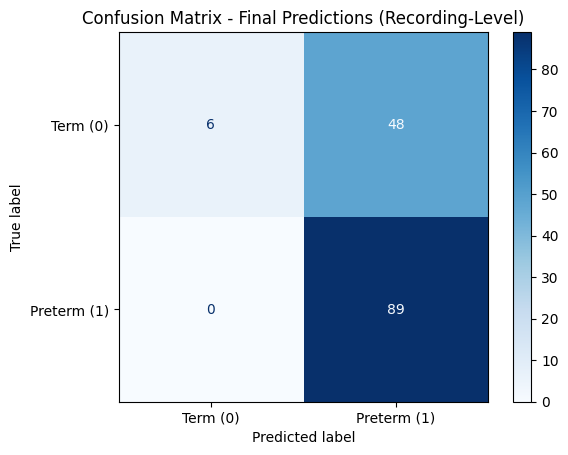

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(final_truths, final_preds))

cm = confusion_matrix(final_truths, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term (0)", "Preterm (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Final Predictions (Recording-Level)")
plt.show()
